#**5_Тренд-сезонная_модель**



In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install statsmodels --upgrade

In [ ]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/DOM')

In [ ]:
!pip install --upgrade xlrd

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import linregress
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from statsmodels.stats.stattools import durbin_watson
from pandas.plotting import autocorrelation_plot
import scipy.stats
import seaborn as sns
from scipy.stats import t as student
from pandas import Grouper
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
filename='Electric_Production.csv'
df=pd.read_csv(filename)

In [ ]:
df.DATE = pd.to_datetime(df.DATE)

In [ ]:
df = df[df['DATE'] != '2018-01-01']

In [ ]:
df.head(5)

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [ ]:
df = df.rename(columns={'IPG2211A2N': 'vt'})

In [ ]:
df = df.set_index('DATE')

In [ ]:
series = df.squeeze()

In [ ]:
series

In [ ]:
pd.set_option('precision', 2)

In [ ]:
df.shape

(396, 1)

In [ ]:
y = series.values

In [ ]:
x = np.arange(1,len(y)+1)

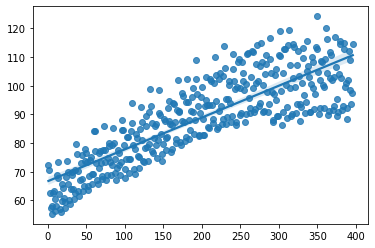

In [ ]:
sns.regplot(x=x,y=y,data=series)

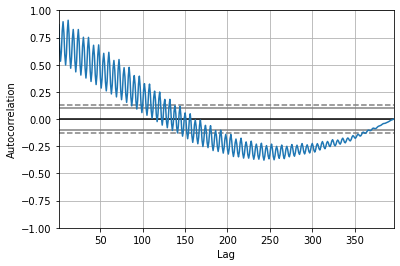

In [ ]:
autocorrelation_plot(y)
plt.show()

In [ ]:
result=seasonal_decompose(series, model='multiplicative', period=12)

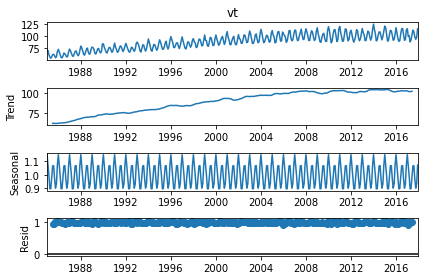

In [ ]:
result.plot() # 1-фактическая составляющая
              # 2-тренд
              # 3-сезонная составляющая
              # 4-ошибки
plt.show()

In [ ]:
result=seasonal_decompose(series, model='additive', period=12)

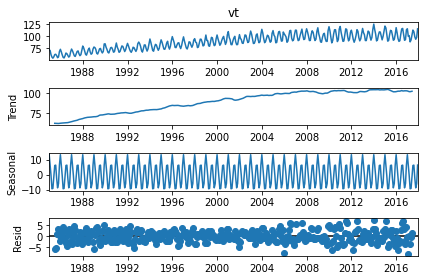

In [ ]:
result.plot() # 1-фактическая составляющая
              # 2-тренд
              # 3-сезонная составляющая
              # 4-ошибки
plt.show()

**создаем x и y (тренировочная и тестовая выборки)**

In [ ]:
x_train, x_test=np.arange(0,324), np.arange(325,len(y)+1)
print(len(x_train),len(x_test))

324 72


In [ ]:
y_train, y_test=y[0:324], y[324:len(y)]
print(len(y_train), len(y_test))

324 72


In [ ]:
series_train = series[:324]
series_train

In [ ]:
series_test = series[324:]
series_test

In [ ]:
rolling_mean=series_train.rolling(window=12).mean() # окно=12, т.к. лаг сезонности = 12
rolling_mean.head(20)

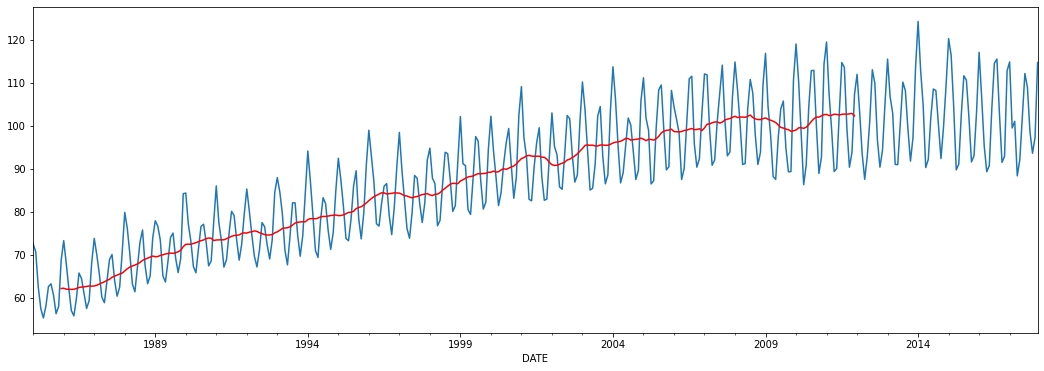

In [ ]:
plt.figure(figsize=(18,6))
series.plot()
rolling_mean.plot(color='red') # первых нет потому что окно =12, выпадают, а последних нет, т.к. они ушли в тестовый набор
plt.show()

In [ ]:
X=y_train-rolling_mean # СОДЕРЖИТ СЕЗОННОСТЬ И СЛУЧАЙНОСТЬ (удаляем тренд)
X.head(20)

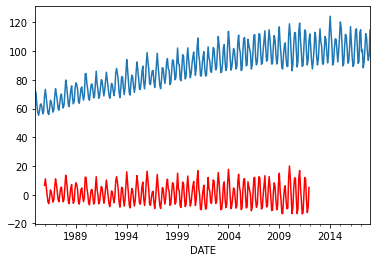

In [ ]:
series.plot()
X.plot(color='red') # первых нет потому что окно =12, выпадают, а последних нет, т.к. они ушли в тестовый набор
plt.show()

**2_Преобразование_и_анализ_ВР (ряд без тренда)**

In [ ]:
groups=X.groupby(pd.Grouper(freq='A'))
# 'A' - это age (группировка по годам)
groups

In [ ]:
years=pd.DataFrame()

In [ ]:
for i,j in groups:
  years[i.year]=j.values

In [ ]:
years.plot(subplots=True,legend=True)
plt.show()

In [ ]:
years.head(5)

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2004,2005,2006,2007,2008,2009,2010,2011,mean,S
0,NaN,11.07,11.06,13.63,8.37,11.93,12.57,10.23,12.60,15.94,...,17.73,14.26,5.82,12.55,12.62,15.00,20.00,16.85,13.43,12.73
1,NaN,5.98,7.14,9.41,7.09,4.70,4.07,4.90,8.85,8.75,...,9.97,5.24,2.89,11.47,6.32,2.91,11.01,5.00,6.52,5.82
2,NaN,0.23,2.40,3.15,3.50,0.74,-0.13,-0.84,3.35,0.85,...,-0.86,2.12,-0.18,-1.24,-1.58,-3.44,-1.29,-3.34,0.53,-0.18
3,NaN,-4.92,-3.31,-4.16,-4.90,-5.36,-6.34,-5.93,-5.18,-7.41,...,-9.67,-10.34,-11.16,-9.89,-11.04,-12.87,-13.10,-13.34,-7.98,-8.68
4,NaN,-6.18,-4.85,-6.20,-6.51,-7.00,-4.92,-8.26,-8.60,-9.14,...,-7.66,-9.44,-8.88,-8.82,-10.73,-13.22,-8.84,-12.56,-8.17,-8.87


In [ ]:
years['mean']=years.mean(axis=1) # делает столбец в который выводится среднее в строке, т.е. за 3 года
years.shape

(12, 28)

**4. КОРРЕКТИРУЕМ СЕЗОННЫЙ КОЭФФИЦИЕНТ**

In [ ]:
k = years['mean'].mean() # поправочный коэффициент

In [ ]:
years.iloc[:,:27]

In [ ]:
k

0.702282304526749

In [ ]:
years['S'] = years['mean'] - k # скорректированный сезонный коэффициент

In [ ]:
s=years['S']

In [ ]:
sez=pd.concat([s for i in range(27)], ignore_index = True)
sez.index=series_train.index
sez # ряд с сезонными составляющими

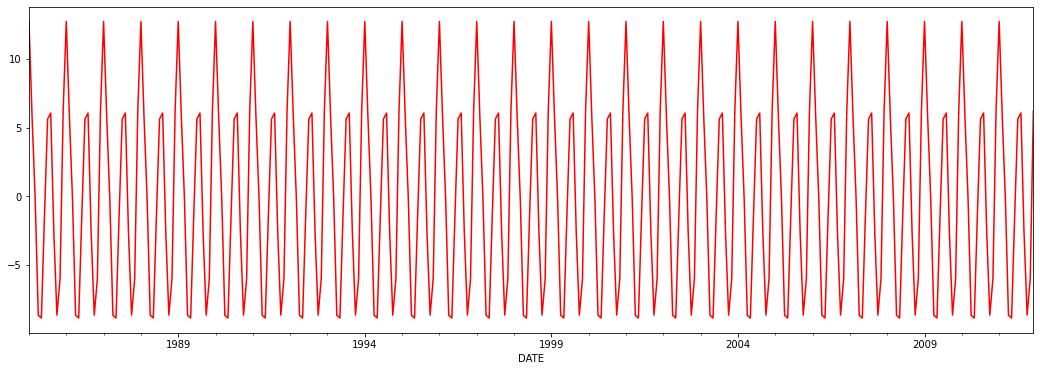

In [ ]:
plt.figure(figsize=(18,6))
sez.plot(color='red')
plt.show()

In [ ]:
y_des=y_train - sez # вычлили сезонную составляющую
y_des # это ряд по которому можно строить тренд (т.е. ряд ,без сезонной составляющей

DATE
1985-01-01     59.78
1985-02-01     64.85
1985-03-01     62.63
1985-04-01     66.15
1985-05-01     64.19
               ...  
2011-08-01    107.54
2011-09-01    102.09
2011-10-01     99.02
2011-11-01     99.84
2011-12-01    101.13
Name: S, Length: 324, dtype: float64

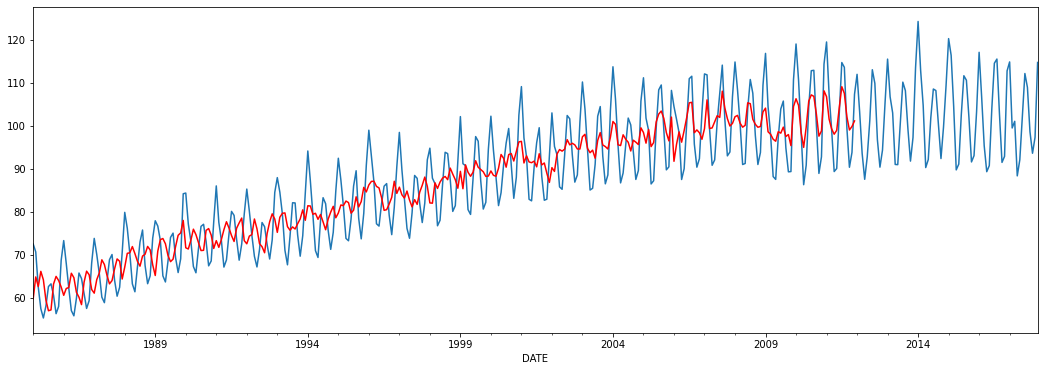

In [ ]:
plt.figure(figsize=(18,6))
series.plot()
y_des.plot(color='red')
#y_pred.plot()
plt.show()

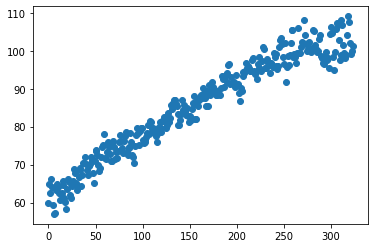

In [ ]:
plt.scatter(x_train,y_des)
plt.show()

In [ ]:
coef=np.polyfit(x_train, y_des, deg=1) # коэффициенты тренда
coef

array([ 0.13517038, 63.90132263])

In [ ]:
sss = sez=pd.concat([s for i in range(6)], ignore_index = True)

Прогноз:

In [ ]:
y_pred=coef[0]*x_test+coef[1]+sez # s- это сезонная составляющая, а остальные 2(тренд+случайная) уже включены, на них обучали
y_pred

In [ ]:
R2=r2_score(y_test, y_pred)
R2

-0.48357187706987714

In [ ]:
MSE=mean_squared_error(y_test, y_pred)
MSE

125.03748547552757

--------------------------------------------------------------------------------

In [ ]:
y_pred

In [ ]:
i = pd.Series(index = series.index[324:], data=y_pred.values)
i

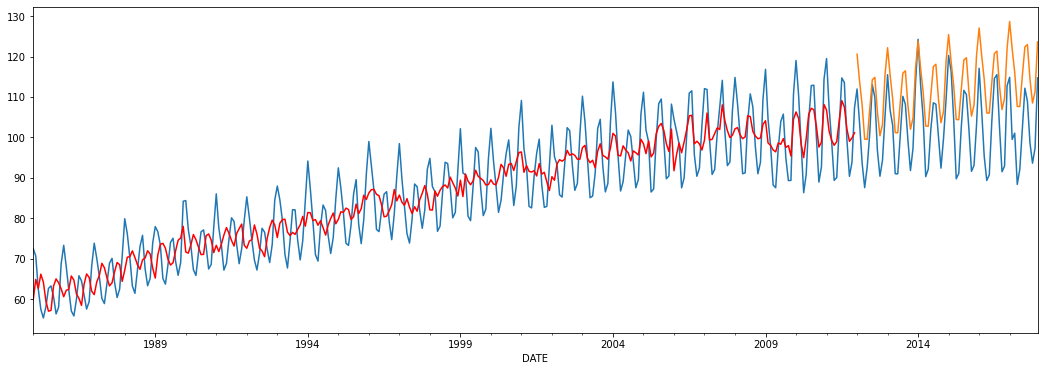

In [ ]:
plt.figure(figsize=(18,6))
series.plot()
y_des.plot(color='red')
i.plot()
plt.show()

# **Строим тренд-сезонную модель на всех данных**

**25.	Постройте на всех данных лучшую модель. Если это тренд-сезонная модель, то см. пп.7-18.**

In [ ]:
series.shape

(396,)

In [ ]:
rolling_mean=series.rolling(window=12).mean()
rolling_mean.head(20)

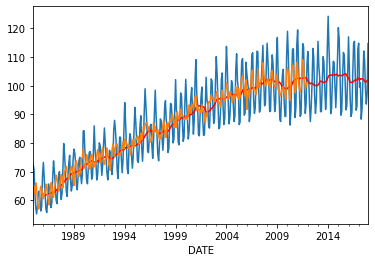

In [ ]:
series.plot()
rolling_mean.plot(color='red')
#X.plot()
y_des.plot()
plt.show()

In [ ]:
X=y-rolling_mean
X.head(20)

DATE
1985-01-01      NaN
1985-02-01      NaN
1985-03-01      NaN
1985-04-01      NaN
1985-05-01      NaN
1985-06-01      NaN
1985-07-01      NaN
1985-08-01      NaN
1985-09-01      NaN
1985-10-01      NaN
1985-11-01      NaN
1985-12-01     6.55
1986-01-01    11.07
1986-02-01     5.98
1986-03-01     0.23
1986-04-01    -4.92
1986-05-01    -6.18
1986-06-01    -2.24
1986-07-01     3.36
1986-08-01     1.97
Name: vt, dtype: float64

In [ ]:
groups=X.groupby(Grouper(freq='A'))

In [ ]:
years=pd.DataFrame()

In [ ]:
for name, group in groups:
  years[name.year]=group.values

In [ ]:
years['mean']=years.mean(axis=1)
years

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,mean
0,NaN,11.07,11.06,13.63,8.37,11.93,12.57,10.23,12.60,15.94,...,15.00,20.00,16.85,10.30,15.21,21.19,16.87,14.30,12.27,13.73
1,NaN,5.98,7.14,9.41,7.09,4.70,4.07,4.90,8.85,8.75,...,2.91,11.01,5.00,2.04,6.16,9.30,12.69,4.69,-2.49,6.31
2,NaN,0.23,2.40,3.15,3.50,0.74,-0.13,-0.84,3.35,0.85,...,-3.44,-1.29,-3.34,-7.29,1.63,1.04,0.80,-5.86,-1.41,0.08
3,NaN,-4.92,-3.31,-4.16,-4.90,-5.36,-6.34,-5.93,-5.18,-7.41,...,-12.87,-13.10,-13.34,-13.16,-10.64,-13.38,-13.88,-11.86,-14.02,-8.89
4,NaN,-6.18,-4.85,-6.20,-6.51,-7.00,-4.92,-8.26,-8.60,-9.14,...,-13.22,-8.84,-12.56,-8.18,-10.53,-11.63,-12.44,-10.42,-10.40,-8.63
5,NaN,-2.24,-0.16,-0.77,-1.84,-1.60,0.83,-3.93,-2.21,-0.85,...,-2.96,4.09,0.31,0.34,-0.77,-1.98,-0.95,2.77,-0.17,-0.58
6,NaN,3.36,4.56,4.76,3.63,3.33,5.78,2.59,5.18,4.35,...,4.28,11.80,12.04,12.37,8.93,4.82,7.78,13.03,10.02,6.92
7,NaN,1.97,5.29,7.07,4.71,3.65,4.68,1.84,4.68,2.97,...,6.28,11.30,10.87,9.51,7.10,4.46,6.54,13.59,7.35,7.01
8,NaN,-1.54,-0.92,-1.47,-1.18,-0.71,-0.95,-2.24,-2.97,-3.32,...,-4.35,-1.92,-3.20,-3.38,-2.01,-3.41,-2.26,0.77,-2.62,-1.96
9,NaN,-5.11,-4.90,-5.94,-4.83,-6.46,-5.88,-5.59,-7.94,-7.87,...,-9.80,-13.08,-12.43,-9.75,-9.62,-11.49,-12.52,-10.50,-7.80,-8.40


In [ ]:
k=years['mean'].mean()
k

0.5895809290824917

In [ ]:
years['S']=years['mean']-k
years

,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2010,2011,2012,2013,2014,2015,2016,2017,mean,S
0,NaN,11.07,11.06,13.63,8.37,11.93,12.57,10.23,12.60,15.94,...,20.00,16.85,10.30,15.21,21.19,16.87,14.30,12.27,13.73,13.14
1,NaN,5.98,7.14,9.41,7.09,4.70,4.07,4.90,8.85,8.75,...,11.01,5.00,2.04,6.16,9.30,12.69,4.69,-2.49,6.31,5.72
2,NaN,0.23,2.40,3.15,3.50,0.74,-0.13,-0.84,3.35,0.85,...,-1.29,-3.34,-7.29,1.63,1.04,0.80,-5.86,-1.41,0.08,-0.51
3,NaN,-4.92,-3.31,-4.16,-4.90,-5.36,-6.34,-5.93,-5.18,-7.41,...,-13.10,-13.34,-13.16,-10.64,-13.38,-13.88,-11.86,-14.02,-8.89,-9.48
4,NaN,-6.18,-4.85,-6.20,-6.51,-7.00,-4.92,-8.26,-8.60,-9.14,...,-8.84,-12.56,-8.18,-10.53,-11.63,-12.44,-10.42,-10.40,-8.63,-9.22
5,NaN,-2.24,-0.16,-0.77,-1.84,-1.60,0.83,-3.93,-2.21,-0.85,...,4.09,0.31,0.34,-0.77,-1.98,-0.95,2.77,-0.17,-0.58,-1.17
6,NaN,3.36,4.56,4.76,3.63,3.33,5.78,2.59,5.18,4.35,...,11.80,12.04,12.37,8.93,4.82,7.78,13.03,10.02,6.92,6.33
7,NaN,1.97,5.29,7.07,4.71,3.65,4.68,1.84,4.68,2.97,...,11.30,10.87,9.51,7.10,4.46,6.54,13.59,7.35,7.01,6.42
8,NaN,-1.54,-0.92,-1.47,-1.18,-0.71,-0.95,-2.24,-2.97,-3.32,...,-1.92,-3.20,-3.38,-2.01,-3.41,-2.26,0.77,-2.62,-1.96,-2.55
9,NaN,-5.11,-4.90,-5.94,-4.83,-6.46,-5.88,-5.59,-7.94,-7.87,...,-13.08,-12.43,-9.75,-9.62,-11.49,-12.52,-10.50,-7.80,-8.40,-8.99


In [ ]:
s=years['S']

In [ ]:
sez=pd.concat([s for i in range(33)], ignore_index = True)
sez.index=df.index
sez.head()

In [ ]:
y_des=y-sez
y_des.head()

DATE
1985-01-01    59.37
1985-02-01    64.95
1985-03-01    62.96
1985-04-01    66.95
1985-05-01    64.53
Name: S, dtype: float64

In [ ]:
t = np.arange(1, len(y_des)+1)
t

In [ ]:
coef=np.polyfit(t, y_des, deg=1)
coef

array([ 0.1115336 , 66.60537911])

In [ ]:
y_pred=coef[0]*t+coef[1]+sez
y_pred.head()

DATE
1985-01-01    79.86
1985-02-01    72.55
1985-03-01    66.43
1985-04-01    57.57
1985-05-01    57.95
Name: S, dtype: float64

**26.	Оцените точность модели для всех данных с помощью следующих показателей: коэффициента детерминации, MAE, MSE, RMSE. Соответствующие функции приведены в задании 4. Прокомментируйте полученные результаты.**

In [ ]:
R2=r2_score(y,y_pred)
R2

0.9152735304219795

In [ ]:
MAE=mean_absolute_error(y,y_pred) # низкий показатель, хороший
MAE

3.6269863779058023

In [ ]:
MSE=mean_squared_error(y,y_pred) # низкий показатель, хороший
MSE

19.70916483867976

In [ ]:
RMSE=sqrt(MSE) # низкий показатель, хороший
RMSE

4.439500516801385

**27.	Рассчитайте ошибки модели для всех данных. Поместите столбец ошибок 'Error' в таблицу исходных данных. Выведите на экран первые 5 наблюдений.**

In [ ]:
df['Error']=y-y_pred
df.head()

,vt,Error
DATE,,
1985-01-01,72.51,-7.35
1985-02-01,70.67,-1.88
1985-03-01,62.45,-3.98
1985-04-01,57.47,-0.10
1985-05-01,55.32,-2.63


**28.	Постройте линейный график ошибок, воспользовавшись функциеями plot() и show() из модуля matplotlib.pyplot. Прокомментируйте результат.**

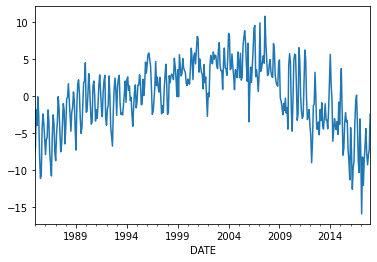

In [ ]:
df.Error.plot()
plt.show()

**29.	Выведите на экран описательные статистики ошибок, воспользовавшись функцией describe(). Прокомментируйте результат.**


In [ ]:
df.Error.describe()

count    3.96e+02
mean    -1.30e-14
std      4.45e+00
min     -1.59e+01
25%     -3.00e+00
50%      3.87e-01
75%      3.25e+00
max      1.07e+01
Name: Error, dtype: float64

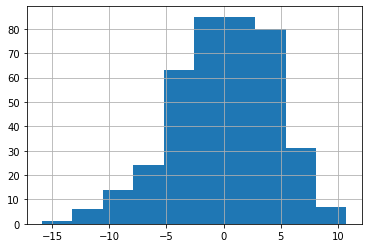

In [ ]:
df.Error.hist()
plt.show()

**30.	Постройте для ошибок гистограмму на основе функции hist(), ядерную оценку плотности на основе функции plot(kind='kde'), Q-Q график на основе функции qqplot() из модуля statsmodels.graphics.gofplots, а также функцией show() из модуля matplotlib.pyplot. Прокомментируйте результат.**

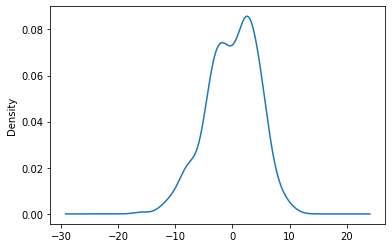

In [ ]:
df.Error.plot(kind='kde')
plt.show()

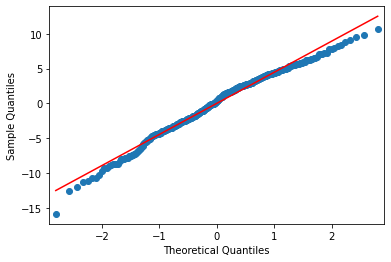

In [ ]:
qqplot(df.Error,line='r')
plt.show()

**31.	Оцените адекватность тренд-сезонной модели на основе теста Дарбина-Уотсона, воспользовавшись функцией durbin_watson() из модуля statsmodels.stats.stattools применительно к остаткам модели. Прокомментируйте результат.**

In [ ]:
d=durbin_watson(df.Error)
d

0.41262036424106335

In [ ]:
4-d

3.5873796357589365

n=60, k=1, alfa=0.05. Для n=60 и k=1, alfa=0.05 dl=1.55, du=1.62.
**4-d>du, поэтому гипотеза об отсутствии автокорреляции не отвергается.**

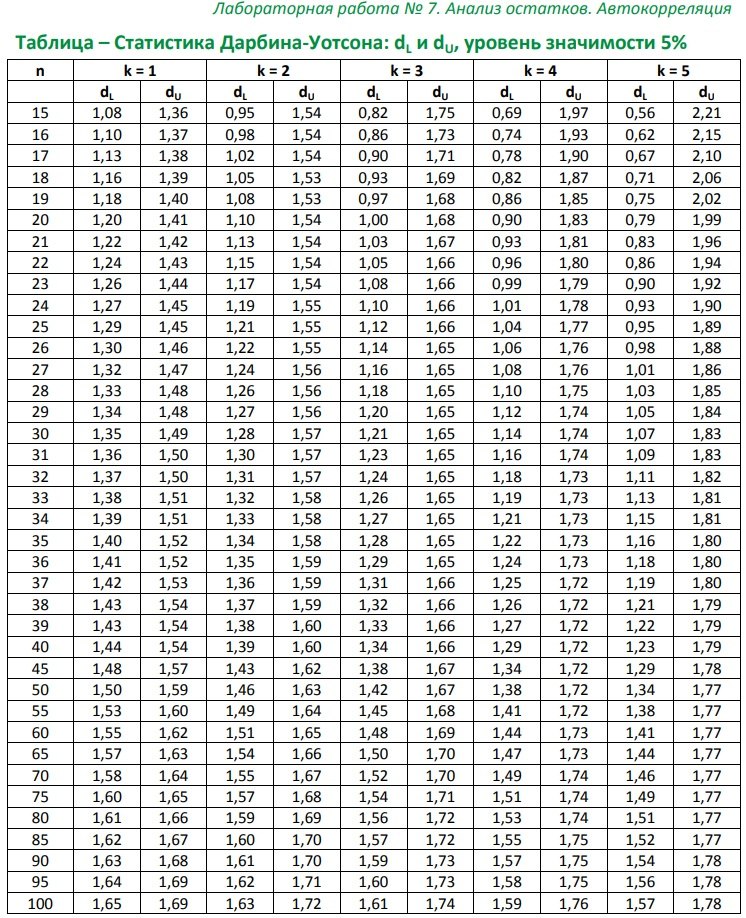

**32.	Постройте для ошибок тренд-сезонной модели коррелограмму, воспользовавшись функцией autocorrelation_plot() из модуля pandas.plotting. Прокомментируйте результат.**

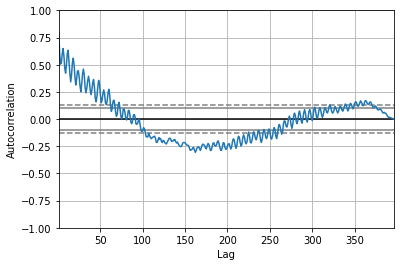

In [ ]:
autocorrelation_plot(df.Error)  # нет автокорреляции, т.к. модель в пределах границ значимости
plt.show()

**33.	На основе переменной y рассчитайте среднее квадратичное отклонение, воспользовавшись функцией sem() из модуля scipy.stats. Запишите результат в переменную sigma и выведите его на экран.**

In [ ]:
sigma =scipy.stats.sem(y)
sigma

0.767407444432628

**34.	Рассчитайте двусторонний t критерий Стьюдента для существующего объема выборки и 95% достоверности результата (confidence). Воспользуйтесь функцией t.ppf((1 + confidence) / 2., len(y)-1) из модуля scipy.stats. Запишите результат в переменную tstu и выведите его на экран.**

In [ ]:
confidence=0.95

In [ ]:
tstu=scipy.stats.t.ppf((1 + confidence) / 2., len(y)-1)
tstu

1.9659878660672252

**35.	Сгенерируйте номера наблюдений для прогнозного интервала, равного 12 месяцев (с 49 по 60 наблюдение). Запишите результат в переменную t_new и выведите его на экран.**

In [ ]:
t_new =np.arange(len(y)+1, len(y)+13)
t_new

array([397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408])

**36.	Найдите прогнозные значения цены на материал 2 на год вперед (точечный прогноз). Запишите результат в переменную y_new и выведите его на экран.**

In [ ]:
y_new = coef[0]*t_new+coef[1]+s
y_new

0     124.02
1     116.72
2     110.60
3     101.74
4     102.11
5     110.28
6     117.88
7     118.09
8     109.22
9     102.90
10    105.88
11    118.53
Name: S, dtype: float64

**37.	Рассчитайте верхнюю границу прогнозного интервала, воспользовавшись формулой: y_up=y_new+tstu*sigma. Выведите результат на экран.**

In [ ]:
y_up=y_new+tstu*sigma
y_up

0     125.53
1     118.22
2     112.11
3     103.25
4     103.62
5     111.78
6     119.39
7     119.59
8     110.73
9     104.41
10    107.38
11    120.04
Name: S, dtype: float64

**38.	Рассчитайте нижнюю границу прогнозного интервала, воспользовавшись формулой: y_down=y_new-tstu*sigma. Выведите результат на экран.**

In [ ]:
y_down=y_new-tstu*sigma
y_down

0     122.52
1     115.21
2     109.09
3     100.23
4     100.61
5     108.77
6     116.37
7     116.58
8     107.72
9     101.39
10    104.37
11    117.03
Name: S, dtype: float64

**39.	Нанесите на одну диаграмму фактические значения, значения по модели, точечный и интервальный прогнозы, воспользовавшись функциями figure(), scatter(), plot(), xlabel(), ylabel(), legend() и show() из модуля matplotlib.pyplot.**

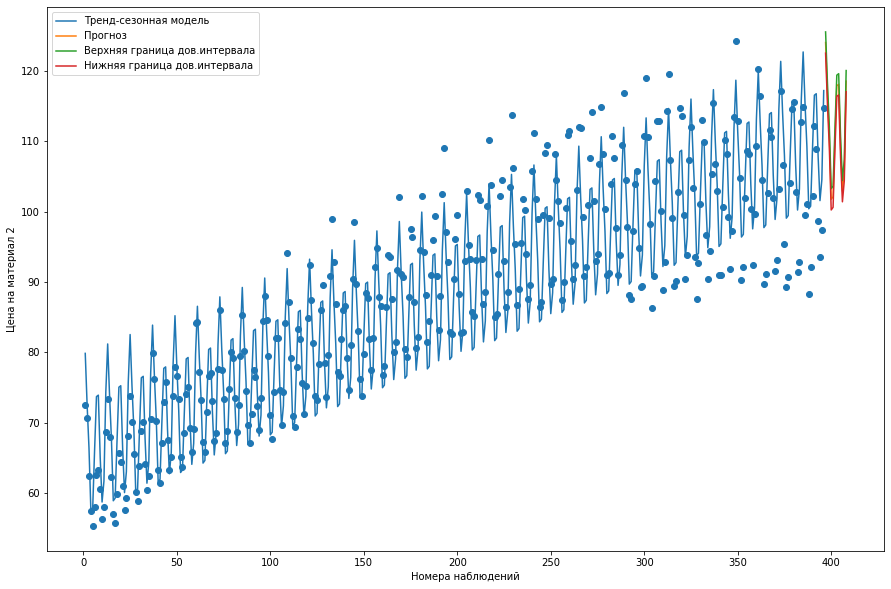

In [ ]:
plt.figure(figsize=(15,10))

plt.scatter(t,y)

plt.plot(t,y_pred)
plt.plot(t_new,y_new)
plt.plot(t_new,y_up)
plt.plot(t_new,y_down)

plt.xlabel('Номера наблюдений')
plt.ylabel('Цена на материал 2')
plt.legend(['Тренд-сезонная модель','Прогноз','Верхняя граница дов.интервала','Нижняя граница дов.интервала'])

plt.show()

**40.	Проведите декомпозицию временного ряда с помощью функции seasonal_decompose(series, model='additive') из модуля statsmodels.tsa.seasonal. Результат запишите в переменную result.**

In [ ]:
series.dtypes

dtype('float64')

In [ ]:
result=seasonal_decompose(series, model='additive', period=12)

**41.	Выведите на экран полученный результат с помощью функций plot() и show() из модуля matplotlib.pyplot.**

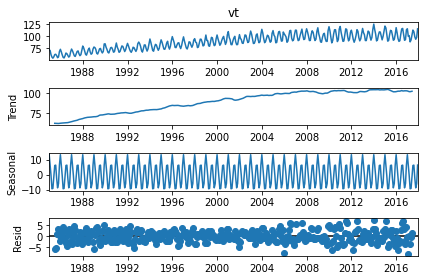

In [ ]:
result.plot() # 1-фактическая составляющая
              # 2-тренд
              # 3-сезонная составляющая
              # 4-ошибки
plt.show()

**42.	Трендовая составляющая содержится в параметре trend. Выведите на экран первые 10 наблюдений.**

In [ ]:
result.trend.head(10)

DATE
1985-01-01      NaN
1985-02-01      NaN
1985-03-01      NaN
1985-04-01      NaN
1985-05-01      NaN
1985-06-01      NaN
1985-07-01    62.20
1985-08-01    62.12
1985-09-01    62.00
1985-10-01    61.97
Name: trend, dtype: float64

**43.	Сезонная составляющая содержится в параметре seasonal. Выведите на экран первые 5 наблюдений.**

In [ ]:
result.seasonal.head()

DATE
1985-01-01    13.22
1985-02-01     5.75
1985-03-01    -0.48
1985-04-01    -9.47
1985-05-01    -9.21
Name: seasonal, dtype: float64

**44.	Остатки содержатся в параметре resid. Выведите на экран первые 10 наблюдений.**

In [ ]:
result.resid.head(10)

DATE
1985-01-01     NaN
1985-02-01     NaN
1985-03-01     NaN
1985-04-01     NaN
1985-05-01     NaN
1985-06-01     NaN
1985-07-01   -5.62
1985-08-01   -5.16
1985-09-01    1.02
1985-10-01    3.19
Name: resid, dtype: float64